In [2]:
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.get_cmap('tab10')
from sklearn import datasets
import torch
device = torch.device('cpu')
from copy import deepcopy
from sbi.neural_nets.flow import build_nsf

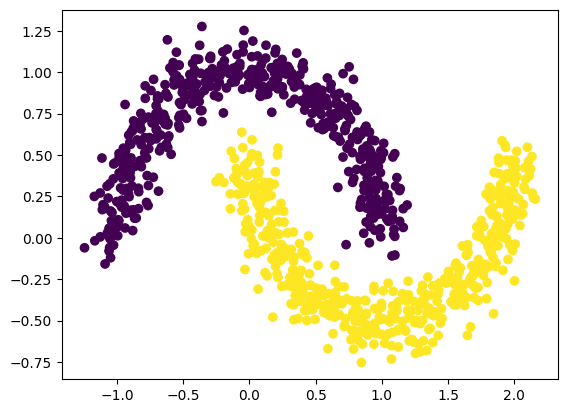

In [3]:
x, y = datasets.make_moons(1_000, noise=.1)
plt.scatter(*x.T, c=y);

In [4]:
flow = build_nsf(
    batch_x=torch.Tensor(x),
    batch_y=torch.Tensor(y[:, None]),
    z_score_x='independent',
    z_score_y='independent',
    hidden_features=100,
    num_transforms=10,
    num_bins=10,
    # embedding_net: nn.Module = nn.Identity(),
    tail_bound=1.,
    # hidden_layers_spline_context: int = 1,
    num_blocks=5,
    dropout_probability=0.,
    use_batch_norm=False,
    ).to(device)

In [5]:
epochs = 1000
batch_size = 128
lr = 1e-3

optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
best_epoch = 0
best_loss = np.inf

for epoch in range(epochs):    
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.Tensor(x).to(device)
    y = torch.Tensor(y[:, None]).to(device)
    
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    
    if loss < best_loss:
        best_epoch = epoch
        best_loss = loss
        best_flow = deepcopy(flow)
        
    print(epoch, float(loss))

0 2.4681153297424316
1 2.289055109024048
2 2.2542543411254883
3 2.265735149383545
4 2.0854454040527344
5 2.018099308013916
6 1.9576668739318848
7 2.0182290077209473
8 2.0199244022369385
9 2.0079288482666016
10 1.9346864223480225
11 1.9515827894210815
12 1.9915512800216675
13 1.8989756107330322
14 1.93514084815979
15 1.8866314888000488
16 1.8167084455490112
17 1.9033843278884888
18 1.8902796506881714
19 1.8510979413986206
20 1.811348795890808
21 1.8079047203063965
22 1.7985014915466309
23 1.7892006635665894
24 1.7151741981506348
25 1.7344499826431274
26 1.8085651397705078
27 1.7388516664505005
28 1.7051913738250732
29 1.694506287574768
30 1.6485090255737305
31 1.66719651222229
32 1.6301072835922241
33 1.5939900875091553
34 1.570369839668274
35 1.5961062908172607
36 1.5848023891448975
37 1.6126011610031128
38 1.6646987199783325
39 1.5290113687515259
40 1.4898910522460938
41 1.700463891029358
42 1.5531859397888184
43 1.6048519611358643
44 1.5803866386413574
45 1.5287079811096191
46 1.6049

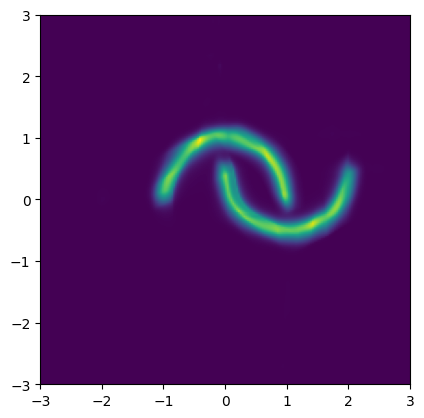

In [6]:
p = 3
n = 200

x = np.linspace(-p, p, n)
y = np.linspace(-p, p, n)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.concatenate(
    [xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)],
    axis=1,
    dtype=np.float32,
    )

with torch.no_grad():
    zgrid = torch.zeros(xy.shape[0])
    for context in [0., 1.]:
        zgrid += best_flow.log_prob(
            torch.tensor(xy), torch.tensor([[context]]*xy.shape[0]),
            ).exp()#.reshape(n, n)
        
plt.imshow(
    zgrid.numpy().reshape(n, n),
    origin='lower',
    aspect='equal',
    extent=(-p, p, -p, p),
    );